# Image Classification with DNN by using 6-dimensional concatenated tensor

In [1]:
!nvidia-smi

Tue Nov  2 12:19:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:01:00.0  On |                  N/A |
| 81%   82C    P2   162W / 240W |   4949MiB /  8116MiB |     98%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#%%capture
#!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
#!chmod +x Miniconda3-latest-Linux-x86_64.sh
#!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
#!time conda install -q -y -c conda-forge rdkit

In [3]:
# Import
import pandas as pd
import numpy as np
from pathlib import Path

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from rdkit import Chem
from rdkit.Chem import AllChem

RDKit WARNING: [12:19:22] Enabling RDKit 2019.09.3 jupyter extensions


In [5]:
dataset = 'oldsmiledata_id_processed_transformed_shuffled'

In [6]:
path = Path('../dataset/oldsmiledata')

In [7]:
list(path.iterdir())

[PosixPath('../dataset/oldsmiledata/test_oldsmiledata_id_processed_transformed_shuffled.csv'),
 PosixPath('../dataset/oldsmiledata/oldsmiledata_id_processed_transformed_rescaled_shuffled.csv'),
 PosixPath('../dataset/oldsmiledata/.ipynb_checkpoints'),
 PosixPath('../dataset/oldsmiledata/mol_images'),
 PosixPath('../dataset/oldsmiledata/train_oldsmiledata_id_processed_transformed_shuffled.csv')]

In [8]:
IMAGES = path/'mol_images'/'all'
train = pd.read_csv(path/f'train_{dataset}.csv')
valid = pd.read_csv(path/f'test_{dataset}.csv')

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23924 entries, 0 to 23923
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   template                        23924 non-null  object 
 1   docked                          23924 non-null  object 
 2   rmsd                            23924 non-null  float64
 3   uniprot_id                      23924 non-null  object 
 4   smiles_template                 23924 non-null  object 
 5   smiles_docked                   23924 non-null  object 
 6   mcs_smartsString                23924 non-null  object 
 7   template_HeavyAtomCount         23924 non-null  int64  
 8   template_NHOHCount              23924 non-null  int64  
 9   template_NOCount                23924 non-null  int64  
 10  template_RingCount              23924 non-null  int64  
 11  template_NumHAcceptors          23924 non-null  int64  
 12  template_NumHDonors             

In [10]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024 entries, 0 to 1023
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   template                        1024 non-null   object 
 1   docked                          1024 non-null   object 
 2   rmsd                            1024 non-null   float64
 3   uniprot_id                      1024 non-null   object 
 4   smiles_template                 1024 non-null   object 
 5   smiles_docked                   1024 non-null   object 
 6   mcs_smartsString                1024 non-null   object 
 7   template_HeavyAtomCount         1024 non-null   int64  
 8   template_NHOHCount              1024 non-null   int64  
 9   template_NOCount                1024 non-null   int64  
 10  template_RingCount              1024 non-null   int64  
 11  template_NumHAcceptors          1024 non-null   int64  
 12  template_NumHDonors             10

# Create dataloader

In [11]:
from fastai.vision.all import *

In [12]:
train['img_temp'] = train['template'] + '.png'
train['img_docked'] = train['docked'] + '.png'
train['image'] = train['template'] + train['docked'] + '.png'
train['is_valid'] = False
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23924 entries, 0 to 23923
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   template                        23924 non-null  object 
 1   docked                          23924 non-null  object 
 2   rmsd                            23924 non-null  float64
 3   uniprot_id                      23924 non-null  object 
 4   smiles_template                 23924 non-null  object 
 5   smiles_docked                   23924 non-null  object 
 6   mcs_smartsString                23924 non-null  object 
 7   template_HeavyAtomCount         23924 non-null  int64  
 8   template_NHOHCount              23924 non-null  int64  
 9   template_NOCount                23924 non-null  int64  
 10  template_RingCount              23924 non-null  int64  
 11  template_NumHAcceptors          23924 non-null  int64  
 12  template_NumHDonors             

In [13]:
valid['img_temp'] = valid['template'] + '.png'
valid['img_docked'] = valid['docked'] + '.png'
valid['image'] = valid['template'] + valid['docked'] + '.png'
valid['is_valid'] = True
valid.head()

,template,docked,rmsd,uniprot_id,smiles_template,smiles_docked,mcs_smartsString,template_HeavyAtomCount,template_NHOHCount,template_NOCount,...,ec_tanimoto_similarity,fc_tanimoto_similarity,log_RMSD,bin_RMSD,Xtransf_ec_tanimoto_similarity,Xtransf_fc_tanimoto_similarity,img_temp,img_docked,image,is_valid
0,2C8Y_C3M,3SHC_B01,6.732,P00734,N[C@@H](Cc1ccccc1)[C@H](O)CNS(=O)(=O)c1ccc2ccccc2c1,N[C@H](Cc1ccccc1)C(=O)N1CCC[C@H]1C(=O)NCc1cc(Cl)ccn1,[#7]-[#6](-[#6]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)-[#6],26,4,5,...,0.240260,0.308219,1.906872,3,0.402597,0.082192,2C8Y_C3M.png,3SHC_B01.png,2C8Y_C3M3SHC_B01.png,True
1,2D1J_D01,1LPZ_CMB,7.109,P00742,O=C(c1cc2c(ccc[n+]2[O-])s1)N1CCN(S(=O)(=O)c2cc3cc(Cl)ccc3[nH]2)CC1,Cc1cccc2c1cc(C(=O)NCc1cc(Cl)cc(Cl)c1)n2Cc1cccc(C(=N)N)c1,"[#6](:[#6]:[#6]:[#6]:,-[#6]:,-[#7](:,-[#6]-[#6]-[#7])-[#6]-[#6]):[#6]:[#6]",31,1,8,...,0.147959,0.203209,1.961362,3,-0.520408,-0.967914,2D1J_D01.png,1LPZ_CMB.png,2D1J_D011LPZ_CMB.png,True
2,4A7I_A7I,1NFX_RDR,7.520,P00742,CC(C)N1CCC(NS(=O)(=O)CCNC(=O)c2ccc(Cl)s2)CC1,O=C1CN(S(=O)(=O)c2cc3ccc(Cl)cc3s2)CCN1Cc1cc2cnccc2n1CCO,"[#6]-[#6](-,:[#6])-,:[#7](-,:[#6]-,:[#6]-,:[#6]-,:[#7])-[#6]-[#6]",24,2,6,...,0.137143,0.177515,2.017566,3,-0.628571,-1.224852,4A7I_A7I.png,1NFX_RDR.png,4A7I_A7I1NFX_RDR.png,True
3,1ZGV_501,1C5O_BAM,3.197,P00734,CCCCNc1cc(C)nc2nc(Nc3cc(Cl)ccc3C)nn12,NC(=[NH2+])c1ccccc1,"[#7]-[#6]-,:[#6](:[#6]:[#6]:[#6]:[#6]):,-[#6]",24,2,6,...,0.064815,0.127451,1.162213,3,-1.351852,-1.725490,1ZGV_501.png,1C5O_BAM.png,1ZGV_5011C5O_BAM.png,True
4,3DA6_BZ9,4W4V_3H8,11.188,P53779,CNc1nccc(-c2cccnc2Oc2c(C)cc(Nc3nc4ccccc4[nH]3)c3ccccc23)n1,Cc1cc(NC(=O)c2cccc(-n3cc(NC(=O)Nc4ccccc4Cl)cn3)c2)ccn1,"[#7]:[#6]:[#6](-,:[#7]-,:[#6]-[#7]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1):[#6]",36,3,8,...,0.190698,0.213270,2.414842,3,-0.093023,-0.867299,3DA6_BZ9.png,4W4V_3H8.png,3DA6_BZ94W4V_3H8.png,True


In [14]:
getters = [ColReader('img_temp', pref=IMAGES), ColReader('img_docked', pref=IMAGES), ColReader('rmsd')]

In [15]:
db = DataBlock(
    blocks = (ImageBlock(), ImageBlock(),  RegressionBlock()), 
    getters = getters,
    splitter=ColSplitter('is_valid'),
    item_tfms=None,
    n_inp=2,
    )

In [16]:
df = pd.concat([train, valid], ignore_index=True)

In [17]:
data = db.datasets(df)
data[0]

(PILImage mode=RGB size=224x224,
 PILImage mode=RGB size=224x224,
 tensor(4.6430))

In [18]:
df = pd.concat([train, valid], ignore_index=True)

In [19]:
df.is_valid.value_counts()

False    23924
True      1024
Name: is_valid, dtype: int64

In [20]:
df.smiles_template.nunique()

1030

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24948 entries, 0 to 24947
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   template                        24948 non-null  object 
 1   docked                          24948 non-null  object 
 2   rmsd                            24948 non-null  float64
 3   uniprot_id                      24948 non-null  object 
 4   smiles_template                 24948 non-null  object 
 5   smiles_docked                   24948 non-null  object 
 6   mcs_smartsString                24948 non-null  object 
 7   template_HeavyAtomCount         24948 non-null  int64  
 8   template_NHOHCount              24948 non-null  int64  
 9   template_NOCount                24948 non-null  int64  
 10  template_RingCount              24948 non-null  int64  
 11  template_NumHAcceptors          24948 non-null  int64  
 12  template_NumHDonors             

In [22]:
dls = db.dataloaders(df, bs=64, shuffle_train=True)

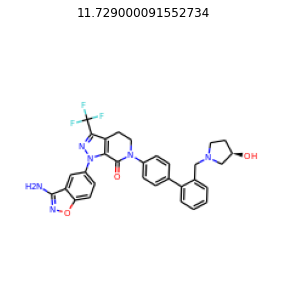

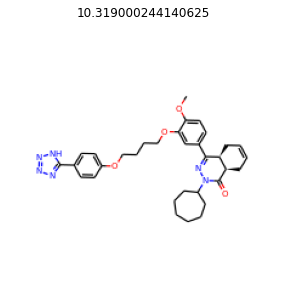

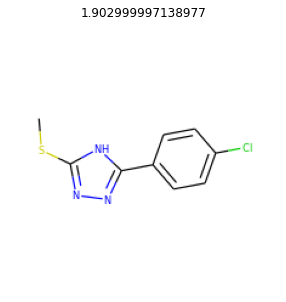

In [23]:
dls.show_batch(max_n=3)

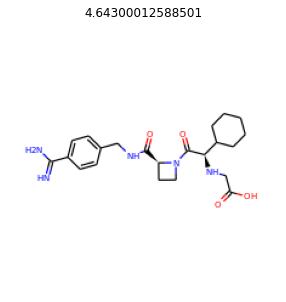

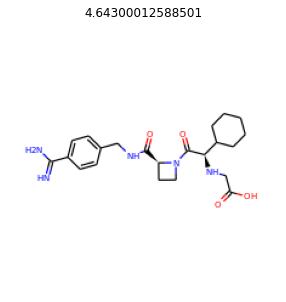

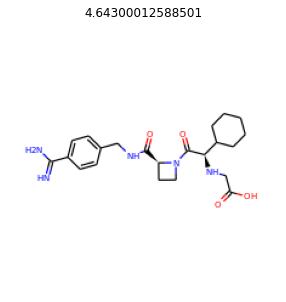

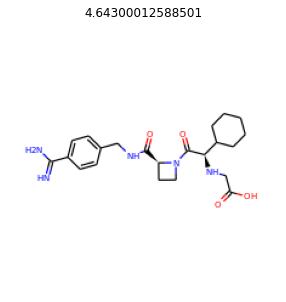

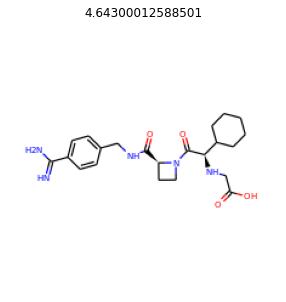

In [24]:
dls.show_batch(max_n=5, unique=True)

# Create 6-dimensional PyTorch model

In [45]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [46]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=ebeb9b5ca763f2659809f129ab87bffb75c26636bcf1f12c77e49c567baec347
  Stored in directory: /home/kjetil/.cache/pip/wheels/63/17/7e/07f1c55a623c96ba9b291c5d2e4901afffb953b032c2470ca6
Successfully built efficientnet-pytorch


In [47]:
from efficientnet_pytorch import *

In [54]:
def open_rcic_image(fn):
    images = []
    for i in range(6):
        file_name = fn+str(i+1)+'.png'
        im = cv2.imread(file_name)
        im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
        images.append(im)
    image = np.dstack(images)
    #print(pil2tensor(image, np.float32).shape)#.div_(255).shape)
    return Image(pil2tensor(image, np.float32).div_(255))
  
class MultiChannelImageList(ImageDataLoaders):
    def open(self, fn):
        return open_rcic_image(fn)

In [48]:
import torchvision
RESNET_MODELS = {
    18: torchvision.models.resnet18,
    34: torchvision.models.resnet34,
    50: torchvision.models.resnet50,
    101: torchvision.models.resnet101,
    152: torchvision.models.resnet152,
}

def resnet_multichannel(depth=50,pretrained=True,num_classes=1108,num_channels=6):
        model = RESNET_MODELS[depth](pretrained=pretrained)
        w = model.conv1.weight
        model.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        model.conv1.weight = nn.Parameter(torch.stack([torch.mean(w, 1)]*num_channels, dim=1))
        return model

    
DENSENET_MODELS = {
    121: torchvision.models.densenet121,
    161: torchvision.models.densenet161,
    169: torchvision.models.densenet169,
    201: torchvision.models.densenet201,
}

def densenet_multichannel(depth=121,pretrained=True,num_classes=1108,num_channels=6):
        model = DENSENET_MODELS[depth](pretrained=pretrained)
        w = model.features.conv0.weight
        model.features.conv0 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        model.features.conv0.weight = nn.Parameter(torch.stack([torch.mean(w, 1)]*num_channels, dim=1))
        return model
        
        
#EFFICIENTNET_MODELS = {
#    'b0': '../input/efficientnet-pytorch/efficientnet-b0-08094119.pth',
#    'b1': '../input/efficientnet-pytorch/efficientnet-b1-dbc7070a.pth',
#    'b2': '../input/efficientnet-pytorch/efficientnet-b2-27687264.pth',
#    'b3': '../input/efficientnet-pytorch/efficientnet-b3-c8376fa2.pth',
#    'b4': '../input/efficientnet-pytorch/efficientnet-b4-e116e8b3.pth',
#    'b5': '../input/efficientnet-pytorch/efficientnet-b5-586e6cc6.pth'
#}


def efficientnet_multichannel(pretrained=True,name='b0',num_classes=1108,num_channels=6,image_size=256):
    model = EfficientNet.from_pretrained('efficientnet-'+name,num_classes=num_classes)
    #model.load_state_dict(torch.load(EFFICIENTNET_MODELS[name]))
    w = model._conv_stem.weight
    #s = model._conv_stem.static_padding
    model._conv_stem = utils.Conv2dStaticSamePadding(num_channels,32,kernel_size=(3, 3), stride=(2, 2), bias=False, image_size = image_size)
    model._conv_stem.weight = nn.Parameter(torch.stack([torch.mean(w, 1)]*num_channels, dim=1))
    return model

In [50]:
def resnet18(pretrained,num_channels=6):
    return resnet_multichannel(depth=18,pretrained=pretrained,num_channels=num_channels)

def _resnet_split(m): return (m[0][6],m[1])

def densenet161(pretrained,num_channels=6):
    return densenet_multichannel(depth=161,pretrained=pretrained,num_channels=num_channels)
  
def _densenet_split(m:nn.Module): return (m[0][0][7],m[1])

def efficientnetb0(pretrained=True,num_channels=6):
    return efficientnet_multichannel(pretrained=pretrained,name='b0',num_channels=num_channels)